# Analyse the ARPEGE previsions

This notebook extract the useful information from the Arpege previsions.
In particular it computes on the France Metopolitan territory:
- the average wind speed
- the total solar energy

In [9]:
from pathlib import Path
import pygrib as pg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm.auto import tqdm
from joblib import Parallel, delayed, Memory

memory = Memory('cache', verbose=0)


In [10]:
start_date = "2022-02-01"
end_date = "2024-04-08"
list_date = pd.date_range(start=start_date, end=end_date, freq="D")
list_date = list_date.strftime("%Y-%m-%d")
cases = ["00H12H", "13H24H", ]  #"25H36H", "37H48H", "49H60H", "61H72H", "73H84H", "85H96H", "97H102H"]
filename_to_save_template = "/shared/home/antoine-2etavant/data/arpege/{date}_SP1_{case}.grib2"
filename = filename_to_save_template.format(date=list_date[-1], case=cases[1])

# Visulation of the data

In [11]:
def print_all_messages(filename):
    i=1
    with open(filename, "r") as f:
        grbs = pg.open(f.name)
        names = np.unique([grb.nameECMF for grb in grbs])
    print("\n".join(names))

print_all_messages(filename)

10 metre U wind component
10 metre V wind component
10 metre eastward wind gust since previous post-processing
10 metre northward wind gust since previous post-processing
10 metre wind direction
10 metre wind speed
2 metre relative humidity
2 metre temperature
Instantaneous 10 metre wind gust
Pressure reduced to MSL
Snow precipitation rate
Surface short-wave (solar) radiation downwards
Total Precipitation
unknown


In [12]:
with pg.open(filename) as grbs:
    grb = grbs[49]
    values = grb.values
    lats, lons = grb.latlons()
    print(grb.name)

10 metre wind speed


In [14]:
metropole_geojson_file = "./metropole.geojson"
metropole = gpd.read_file(metropole_geojson_file)

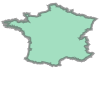

In [15]:
from shapely.geometry import Point, Polygon
import geojson
# create mask if point inside metropole
mask = np.zeros_like(lats, dtype=bool)

metropole = geojson.load(open(metropole_geojson_file))
poly = Polygon(metropole["geometry"]["coordinates"][0][0])
poly

In [16]:
import cartopy.crs as ccrs
from cartopy import feature

/home/ubuntu/.local/mambaforge/envs/latest/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


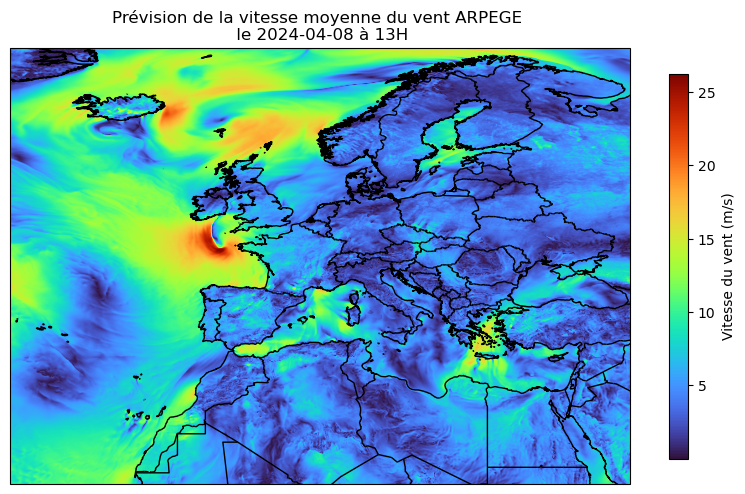

In [17]:
# plot the values overlaped with the metropole
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
im = ax.imshow(values, extent=(lons.min(), lons.max(), lats.min(), lats.max()), cmap="turbo")
cbar = fig.colorbar(im, ax=ax, shrink=0.5)

ax.add_feature(feature.BORDERS.with_scale('10m'), color='black', linewidth=1)
ax.add_feature(feature.COASTLINE.with_scale('10m'), color='black', linewidth=1)

ax.set_title("Prévision de la vitesse moyenne du vent ARPEGE \n le 2024-04-08 à 13H")
cbar.set_label("Vitesse du vent (m/s)")

Surface short-wave (solar) radiation downwards


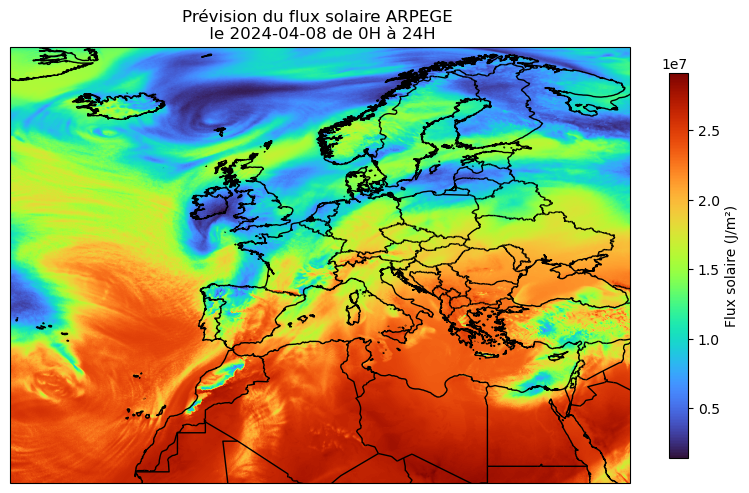

In [18]:
with pg.open(filename) as grbs:
    grb = grbs[168]
    values_flux = grb.values
    lats, lons = grb.latlons()
    print(grb.name)

# plot the values overlaped with the metropole
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
im = ax.imshow(values_flux, extent=(lons.min(), lons.max(), lats.min(), lats.max()), cmap="turbo")
cbar = fig.colorbar(im, ax=ax, shrink=0.5)

ax.add_feature(feature.BORDERS.with_scale('10m'), color='black', linewidth=1)
ax.add_feature(feature.COASTLINE.with_scale('10m'), color='black', linewidth=1)

ax.set_title("Prévision du flux solaire ARPEGE \n le 2024-04-08 de 0H à 24H")
cbar.set_label("Flux solaire (J/m²)")

## Territory mask

Let's create a mask of the pixels included in the France territory.

In [19]:
bouns = poly.envelope.bounds

for i in tqdm(range(lats.shape[0])):
    if lats[i, 0] < bouns[1] or lats[i, -1] > bouns[3]:
        continue
    for j in range(lats.shape[1]):
        if lons[i, j] < bouns[0] or lons[i, j] > bouns[2]:
            continue
        if poly.contains(Point(lons[i, j], lats[i, j])):
            mask[i, j] = True

  0%|          | 0/521 [00:00<?, ?it/s]

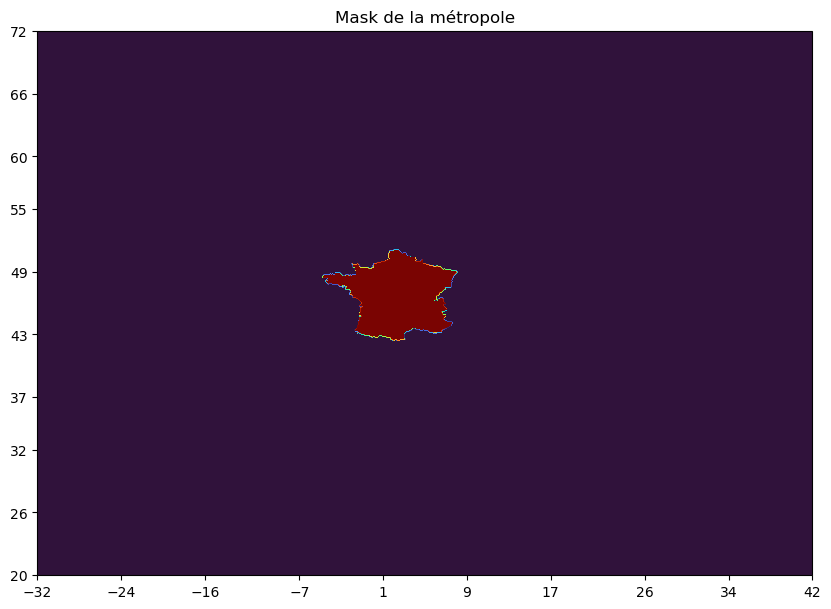

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
im = ax.imshow(mask, extent=(lons.min(), lons.max(), lats.min(), lats.max()), cmap="turbo")
ax.set_title("Mask de la métropole")

# add the x ticks and y ticks
ax.set_xticks( [round(t) for t in np.linspace(lons.min(), lons.max(), 10)])
ax.set_yticks([round(t) for t in np.linspace(lats.min(), lats.max(), 10)])


# Getting the daily sum flux

In [14]:
IDX_SOLAR_SHORT_ACCUM_DAILY = 168

@memory.cache
def get_france_average_of_index(gribfilename, index, mask=mask, verbose=False):
    grbs = pg.open(gribfilename)
    if verbose:
        print(grbs.message(index))
    grb = grbs[index]

    data = grb.values
    #latlongs = grb.latlons()
    grbs.close()
    #lats, lons = latlongs
    value = data.mean(where=mask)
    return value

def get_daily_solar_short_accum(date):
    gribfilename = filename_to_save_template.format(date=date, case=cases[1])
    return get_france_average_of_index(gribfilename, IDX_SOLAR_SHORT_ACCUM_DAILY)

get_daily_solar_short_accum(list_date[1])

4494408.171282355

In [15]:
IDXs_WIND_SPEED_CASE1 = list(range(49,61))[:-1]  # removing the 24h prevision
IDXs_WIND_SPEED_CASE0 = list(range(53,66))

len(IDXs_WIND_SPEED_CASE1) + len(IDXs_WIND_SPEED_CASE0)


def get_instant_wind_speed(date):
    list_wind_speed = []
    for case, list_idx in zip(cases, [IDXs_WIND_SPEED_CASE0, IDXs_WIND_SPEED_CASE1]):
        gribfilename = filename_to_save_template.format(date=date, case=case)
        for idx in list_idx:
            list_wind_speed.append(get_france_average_of_index(gribfilename, idx))
    return list_wind_speed

def get_daily_wind_speed(date):
    return np.mean(get_instant_wind_speed(date))

wind_speed = get_daily_wind_speed(list_date[1])
wind_speed

3.6619046773236836

In [16]:
def get_data_for_date(date):
    try :
        solar = get_daily_solar_short_accum(date)
    except Exception as e:
        print(f"Error for solar {date}: {e}")
        solar = np.nan
    try:
        wind = get_daily_wind_speed(date)
    except Exception as e:
        print(f"Error for wind {date}: {e}")
        wind = np.nan
    return solar, wind

In [22]:
# use Parallel to speed up the computation
results = Parallel(n_jobs=4)(delayed(get_data_for_date)(date) for date in tqdm(list_date))
data = pd.DataFrame([{"sun":r[0], "wind":r[1]}  for r in results], index=list_date[:len(results)])
data.index = pd.to_datetime(data.index)
data.index.name = "date"
data.to_csv("solar_wind_data.csv")

  0%|          | 0/798 [00:00<?, ?it/s]

Error for solar 2022-06-15: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-06-15_SP1_13H24H.grib2
Error for wind 2022-06-15: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-06-15_SP1_00H12H.grib2
Error for solar 2022-11-17: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-17_SP1_13H24H.grib2
Error for wind 2022-11-17: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-17_SP1_00H12H.grib2
Error for solar 2022-11-18: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-18_SP1_13H24H.grib2
Error for wind 2022-11-18: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-18_SP1_00H12H.grib2
Error for solar 2022-11-19: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-19_SP1_13H24H.grib2
Error for wind 2022-11-19: [Errno could not open %s] /shared/home/antoine-2etavant/data/arpege/2022-11-19_SP1_00H12H.grib2
Error for so

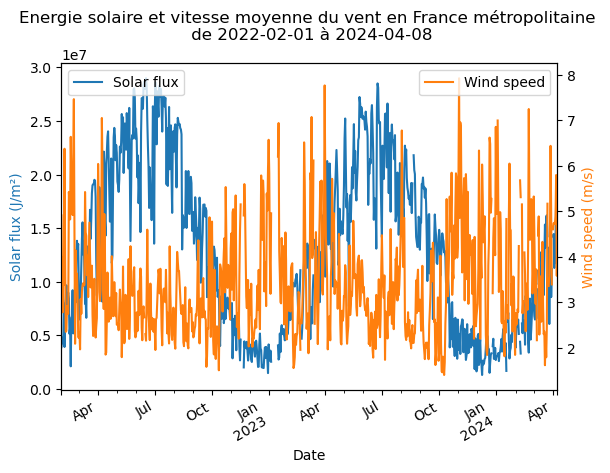

In [52]:
data = pd.read_csv("solar_wind_data.csv", index_col="date", parse_dates=True)
fig, ax = plt.subplots()
ax = data["sun"].plot(ax=ax)
ax2 = ax.twinx()
data["wind"].plot(ax=ax2, color="#ff7f0e")

ax.set_xlabel("Date")
ax.set_ylabel("Solar flux (J/m²)", color=colors[0])
ax2.set_ylabel("Wind speed (m/s)", color=colors[1])
ax.set_title("Energie solaire et vitesse moyenne du vent en France métropolitaine \n de 2022-02-01 à 2024-04-08")

ax.legend(["Solar flux"], loc="upper left")
ax2.legend(["Wind speed"], loc="upper right")
fig.autofmt_xdate()
plt.savefig("daily_weather.png")

# Archive
This following figure is not used but I keep it as it is quite nice.

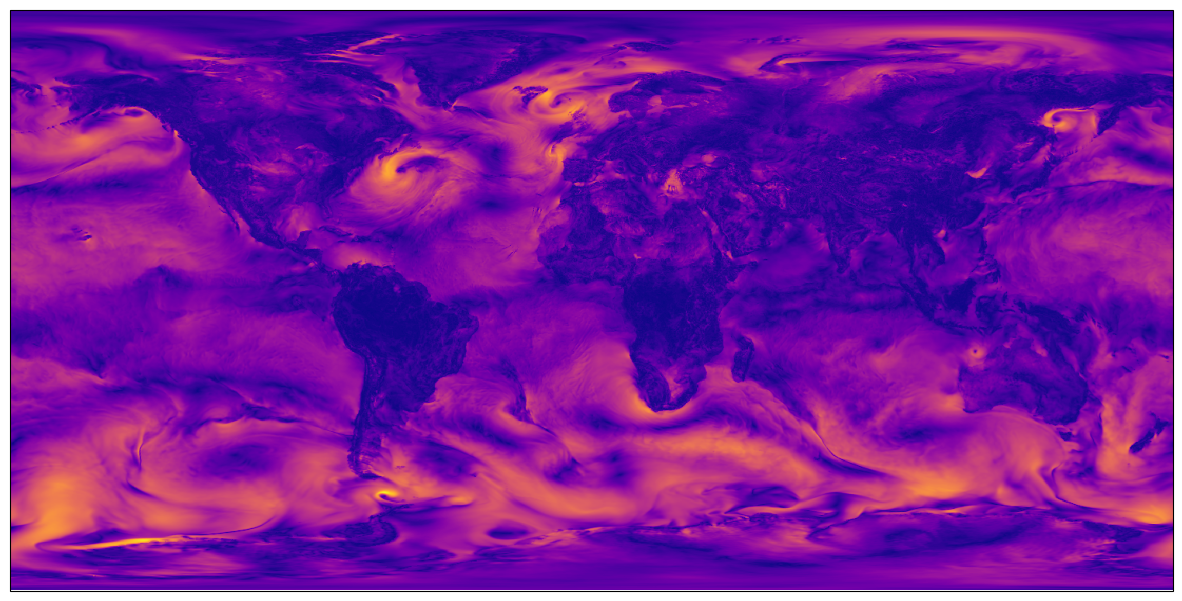

In [115]:
grbs = pg.open(filename)
grb = grbs[19]
data_wind = grb.values
lats, lons = grb.latlons()
grbs.close()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(data_wind, origin='upper', extent=(lons.min(), 360, lats.min(), lats.max()), transform=ccrs.PlateCarree(), cmap="plasma")